In [20]:
import warnings
warnings.filterwarnings('ignore')

In [21]:
%matplotlib inline
import re
from alphalens.utils import get_clean_factor_and_forward_returns
from alphalens.performance import *
from alphalens.plotting import *
from alphalens.tears import *

import seaborn as sns
import matplotlib.pyplot as plt

In [22]:
sns.set_style('whitegrid')
DATA_STORE = '/Volumes/My Book/Data_Analysis/Nasdaq/assets.h5'

In [23]:
performance = pd.read_pickle('single_factor.pickle')
performance.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 755 entries, 2015-01-02 21:00:00+00:00 to 2017-12-29 21:00:00+00:00
Data columns (total 39 columns):
 #   Column                   Non-Null Count  Dtype              
---  ------                   --------------  -----              
 0   period_open              755 non-null    datetime64[ns, UTC]
 1   period_close             755 non-null    datetime64[ns, UTC]
 2   transactions             755 non-null    object             
 3   positions                755 non-null    object             
 4   starting_exposure        755 non-null    float64            
 5   ending_exposure          755 non-null    float64            
 6   starting_value           755 non-null    float64            
 7   ending_value             755 non-null    float64            
 8   starting_cash            755 non-null    float64            
 9   ending_cash              755 non-null    float64            
 10  returns                  755 non-null    float64 

In [24]:
prices = pd.concat([df.to_frame(d) for d, df in performance.prices.dropna().items()],axis=1).T
prices.columns = [re.findall(r"\[(.+)\]", str(col))[0] for col in prices.columns]
prices.index = prices.index.normalize()
prices.info()
prices.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 754 entries, 2015-01-05 00:00:00+00:00 to 2017-12-29 00:00:00+00:00
Columns: 1649 entries, A to NETE
dtypes: float64(1649)
memory usage: 9.5 MB


,A,AAL,AAP,AAPL,ABBV,ABC,ABG,ABT,ACAD,ACC,...,CHE,EGBN,HAE,NYT,APTV,AVAV,GDOT,GTN,RVNC,NETE
2015-01-05 00:00:00+00:00,39.8,53.875,156.47,106.25,64.65,89.69,74.0,44.91,31.1,42.34,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-06 00:00:00+00:00,39.8,53.875,156.47,106.25,64.65,89.69,74.0,44.91,31.1,42.34,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-07 00:00:00+00:00,39.8,53.875,156.47,106.25,64.65,89.69,74.0,44.91,31.1,42.34,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-08 00:00:00+00:00,39.8,53.875,156.47,106.25,64.65,89.69,74.0,44.91,31.1,42.34,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-09 00:00:00+00:00,39.8,53.875,156.47,106.25,64.65,89.69,74.0,44.91,31.1,42.34,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
factor_data = pd.concat([df.to_frame(d) for d, df in performance.factor_data.dropna().items()],axis=1).T
factor_data.columns = [re.findall(r"\[(.+)\]", str(col))[0] for col in factor_data.columns]
factor_data.index = factor_data.index.normalize()
factor_data = factor_data.stack()
factor_data.index.names = ['date', 'asset']
factor_data.head()

date                       asset
2015-01-05 00:00:00+00:00  A        2707.0
                           AAL       870.0
                           AAP      1253.0
                           AAPL     2977.0
                           ABBV     2806.0
dtype: float64

In [26]:
with pd.HDFStore(DATA_STORE) as store:
    sp500 = store['sp500/stooq'].close
sp500 = sp500.resample('D').ffill().tz_localize('utc').filter(prices.index.get_level_values(0))
sp500.head()

2015-01-05 00:00:00+00:00    2020.58
2015-01-06 00:00:00+00:00    2002.61
2015-01-07 00:00:00+00:00    2025.90
2015-01-08 00:00:00+00:00    2062.14
2015-01-09 00:00:00+00:00    2044.81
Name: close, dtype: float64

In [27]:
HOLDING_PERIODS = (5, 10, 21, 42)
QUANTILES = 5
alphalens_data = get_clean_factor_and_forward_returns(factor=factor_data,
                                                      prices=prices,
                                                      periods=HOLDING_PERIODS,
                                                      quantiles=QUANTILES)

Dropped 5.6% entries from factor data: 5.6% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


In [28]:
alphalens_data.head()

5D       10D       21D       42D  \
date                      asset                                           
2015-01-05 00:00:00+00:00 A      0.007789 -0.046985 -0.027889  0.072864   
                          AAL   -0.079722 -0.020882 -0.095684 -0.103295   
                          AAP    0.015722 -0.024350 -0.003196 -0.010865   
                          AAPL   0.028235  0.023247  0.116518  0.214965   
                          ABBV   0.017169 -0.018561 -0.061098 -0.064811   

                                 factor  factor_quantile  
date                      asset                           
2015-01-05 00:00:00+00:00 A      2707.0                5  
                          AAL     870.0                1  
                          AAP    1253.0                2  
                          AAPL   2977.0                5  
                          ABBV   2806.0                5

In [29]:
alphalens_data.reset_index().head().to_csv('factor_data.csv', index=False)

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,1.0,1011.0,303.057978,188.562449,142313,20.020145
2,352.0,1636.0,856.678631,234.705707,142117,19.992572
3,794.0,2153.0,1417.174265,259.942787,142019,19.978786
4,1273.0,2621.0,1979.178578,253.504821,142117,19.992572
5,1827.0,3050.0,2519.578804,227.348609,142283,20.015925


Returns Analysis


,10D,21D,42D,5D
Ann. alpha,0.000,0.000,0.000,0.000
beta,0.000,0.000,0.000,0.000
Mean Period Wise Return Top Quantile (bps),9.110,3.948,-0.376,11.724
Mean Period Wise Return Bottom Quantile (bps),-13.259,-4.742,-1.979,-16.862
Mean Period Wise Spread (bps),22.343,8.711,1.582,28.587


Information Analysis


,5D,10D,21D,42D
IC Mean,0.022,0.026,0.017,0.003
IC Std.,0.140,0.127,0.116,0.115
Risk-Adjusted IC,0.160,0.207,0.148,0.027
t-stat(IC),4.261,5.529,3.953,0.729
p-value(IC),0.000,0.000,0.000,0.466
IC Skew,0.372,0.266,0.115,0.113
IC Kurtosis,0.054,-0.515,-0.333,-0.557


Turnover Analysis


,5D,10D,21D,42D
Quantile 1 Mean Turnover,0.411,0.590,0.830,0.831
Quantile 2 Mean Turnover,0.645,0.740,0.804,0.812
Quantile 3 Mean Turnover,0.679,0.765,0.808,0.812
Quantile 4 Mean Turnover,0.642,0.741,0.810,0.814
Quantile 5 Mean Turnover,0.394,0.569,0.811,0.819


,5D,10D,21D,42D
Mean Factor Rank Autocorrelation,0.713,0.454,-0.013,-0.017


<Figure size 640x480 with 0 Axes>

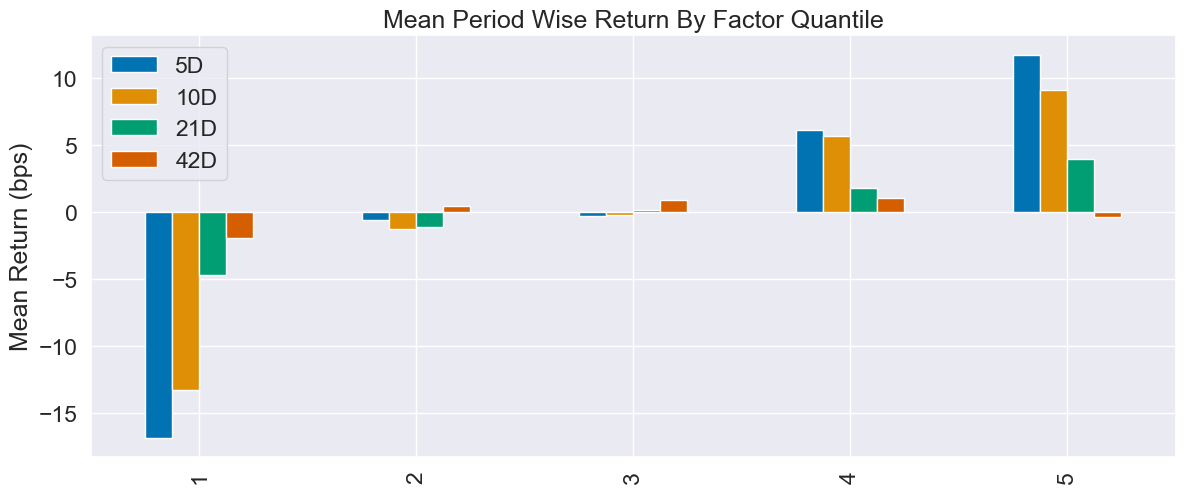

In [30]:
create_summary_tear_sheet(alphalens_data)

In [31]:
mean_return_by_q, std_err = mean_return_by_quantile(alphalens_data)
mean_return_by_q_norm = mean_return_by_q.apply(lambda x: x.add(1).pow(1/int(x.name[:-1])).sub(1))

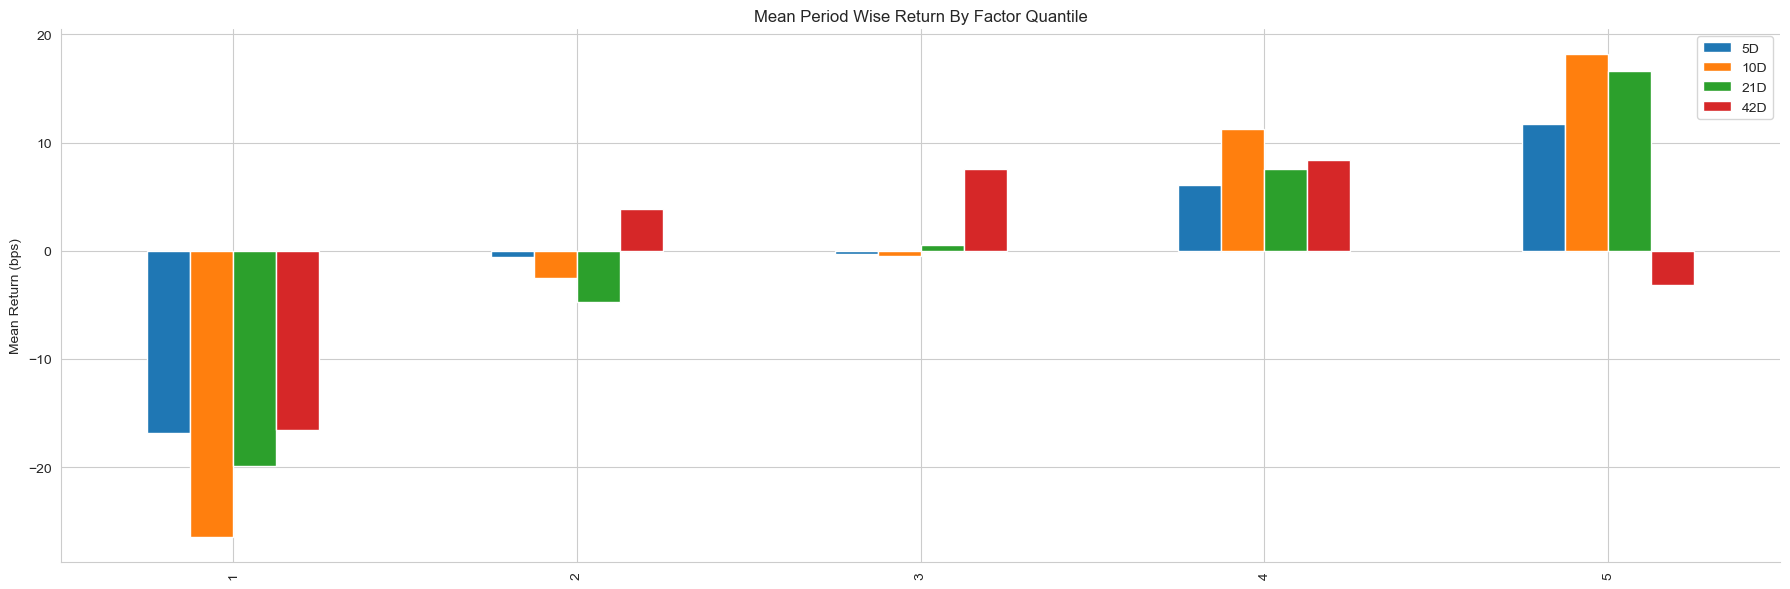

In [32]:
plot_quantile_returns_bar(mean_return_by_q)
plt.tight_layout()
sns.despine();

In [33]:
mean_return_by_q_daily, std_err = mean_return_by_quantile(alphalens_data, by_date=True)

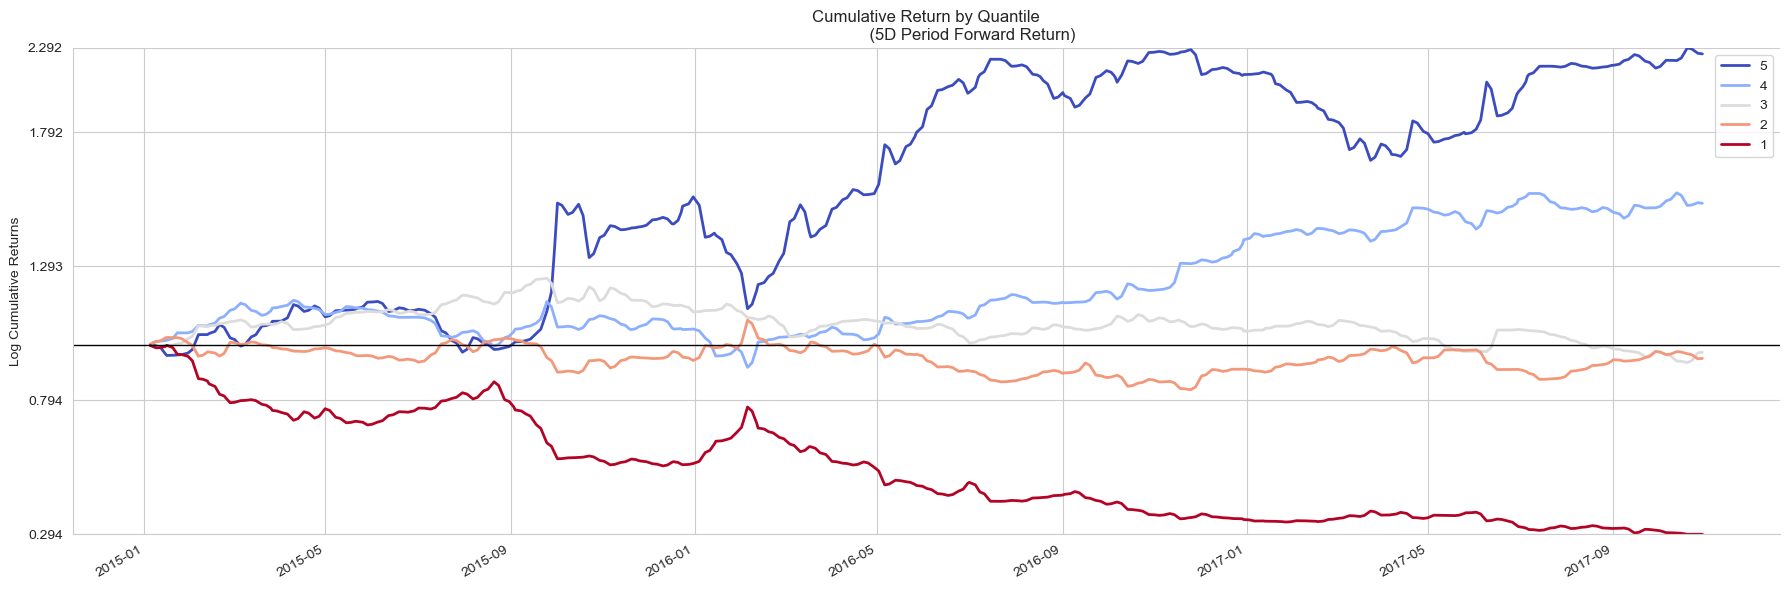

In [34]:
plot_cumulative_returns_by_quantile(mean_return_by_q_daily['5D'], period='5D', freq=None)
plt.tight_layout()
sns.despine();

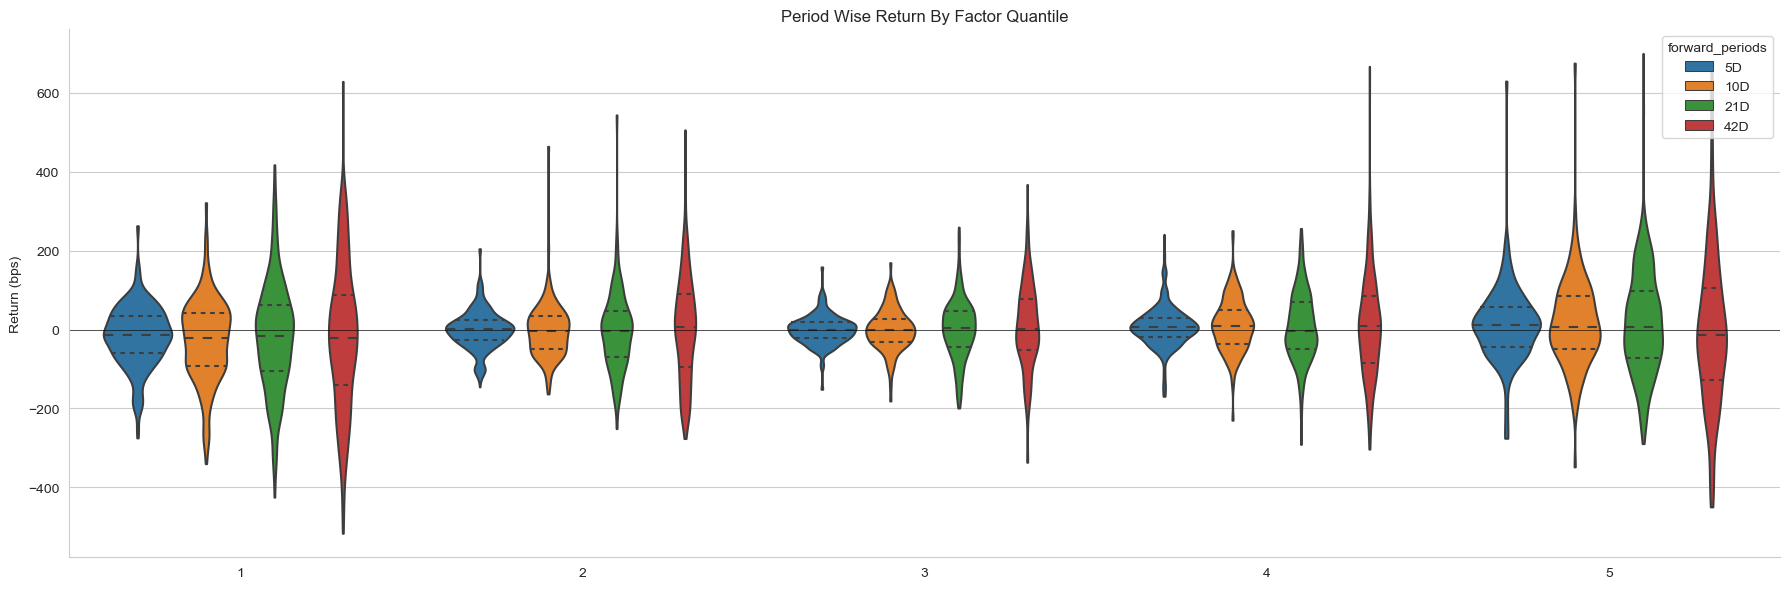

In [35]:
plot_quantile_returns_violin(mean_return_by_q_daily)
plt.tight_layout()
sns.despine();

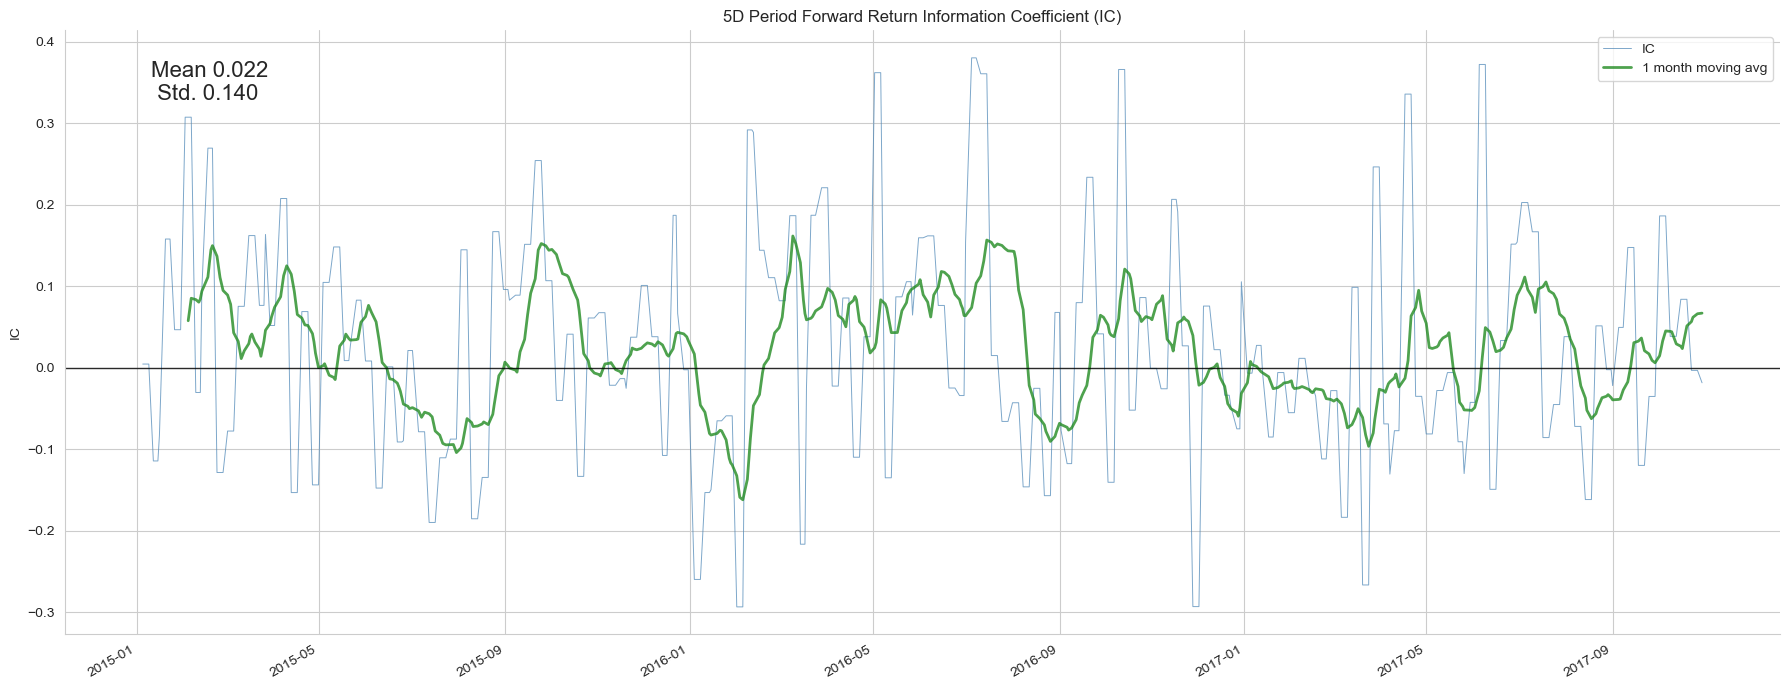

In [36]:
ic = factor_information_coefficient(alphalens_data)
plot_ic_ts(ic[['5D']])
plt.tight_layout()
sns.despine();

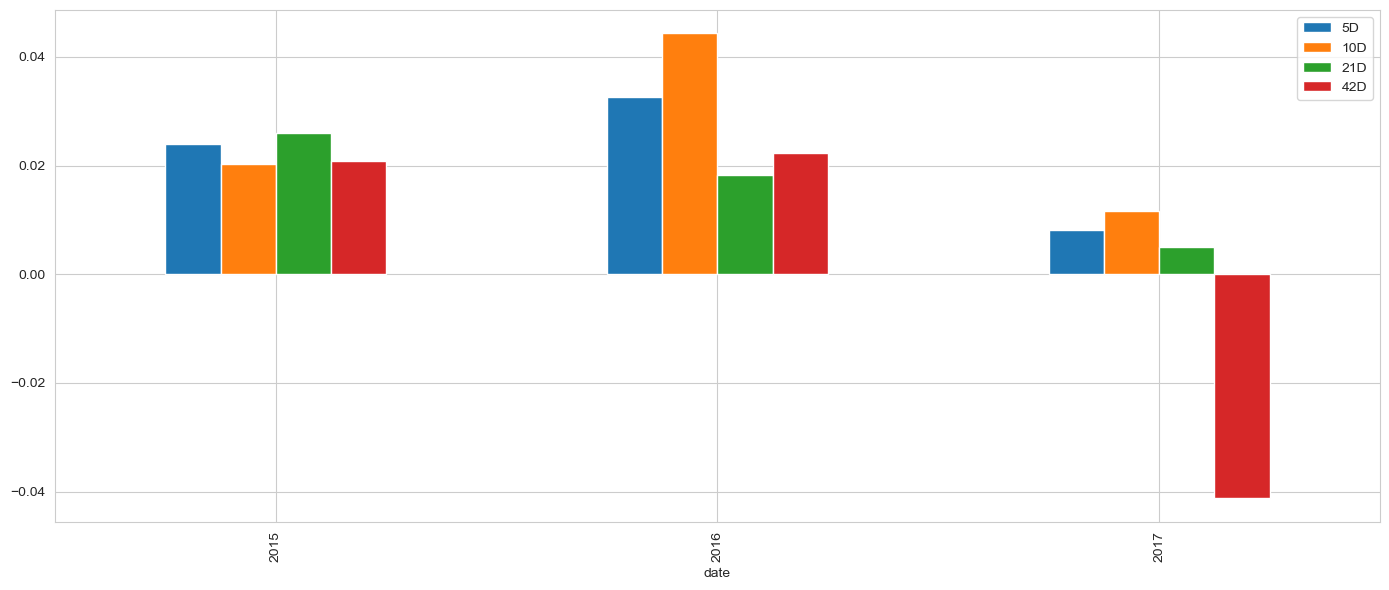

In [37]:
ic = factor_information_coefficient(alphalens_data)
ic_by_year = ic.resample('A').mean()
ic_by_year.index = ic_by_year.index.year
ic_by_year.plot.bar(figsize=(14, 6))
plt.tight_layout();

Turnover Analysis


,5D,10D,21D,42D
Quantile 1 Mean Turnover,0.411,0.590,0.830,0.831
Quantile 2 Mean Turnover,0.645,0.740,0.804,0.812
Quantile 3 Mean Turnover,0.679,0.765,0.808,0.812
Quantile 4 Mean Turnover,0.642,0.741,0.810,0.814
Quantile 5 Mean Turnover,0.394,0.569,0.811,0.819


,5D,10D,21D,42D
Mean Factor Rank Autocorrelation,0.713,0.454,-0.013,-0.017


<Figure size 640x480 with 0 Axes>

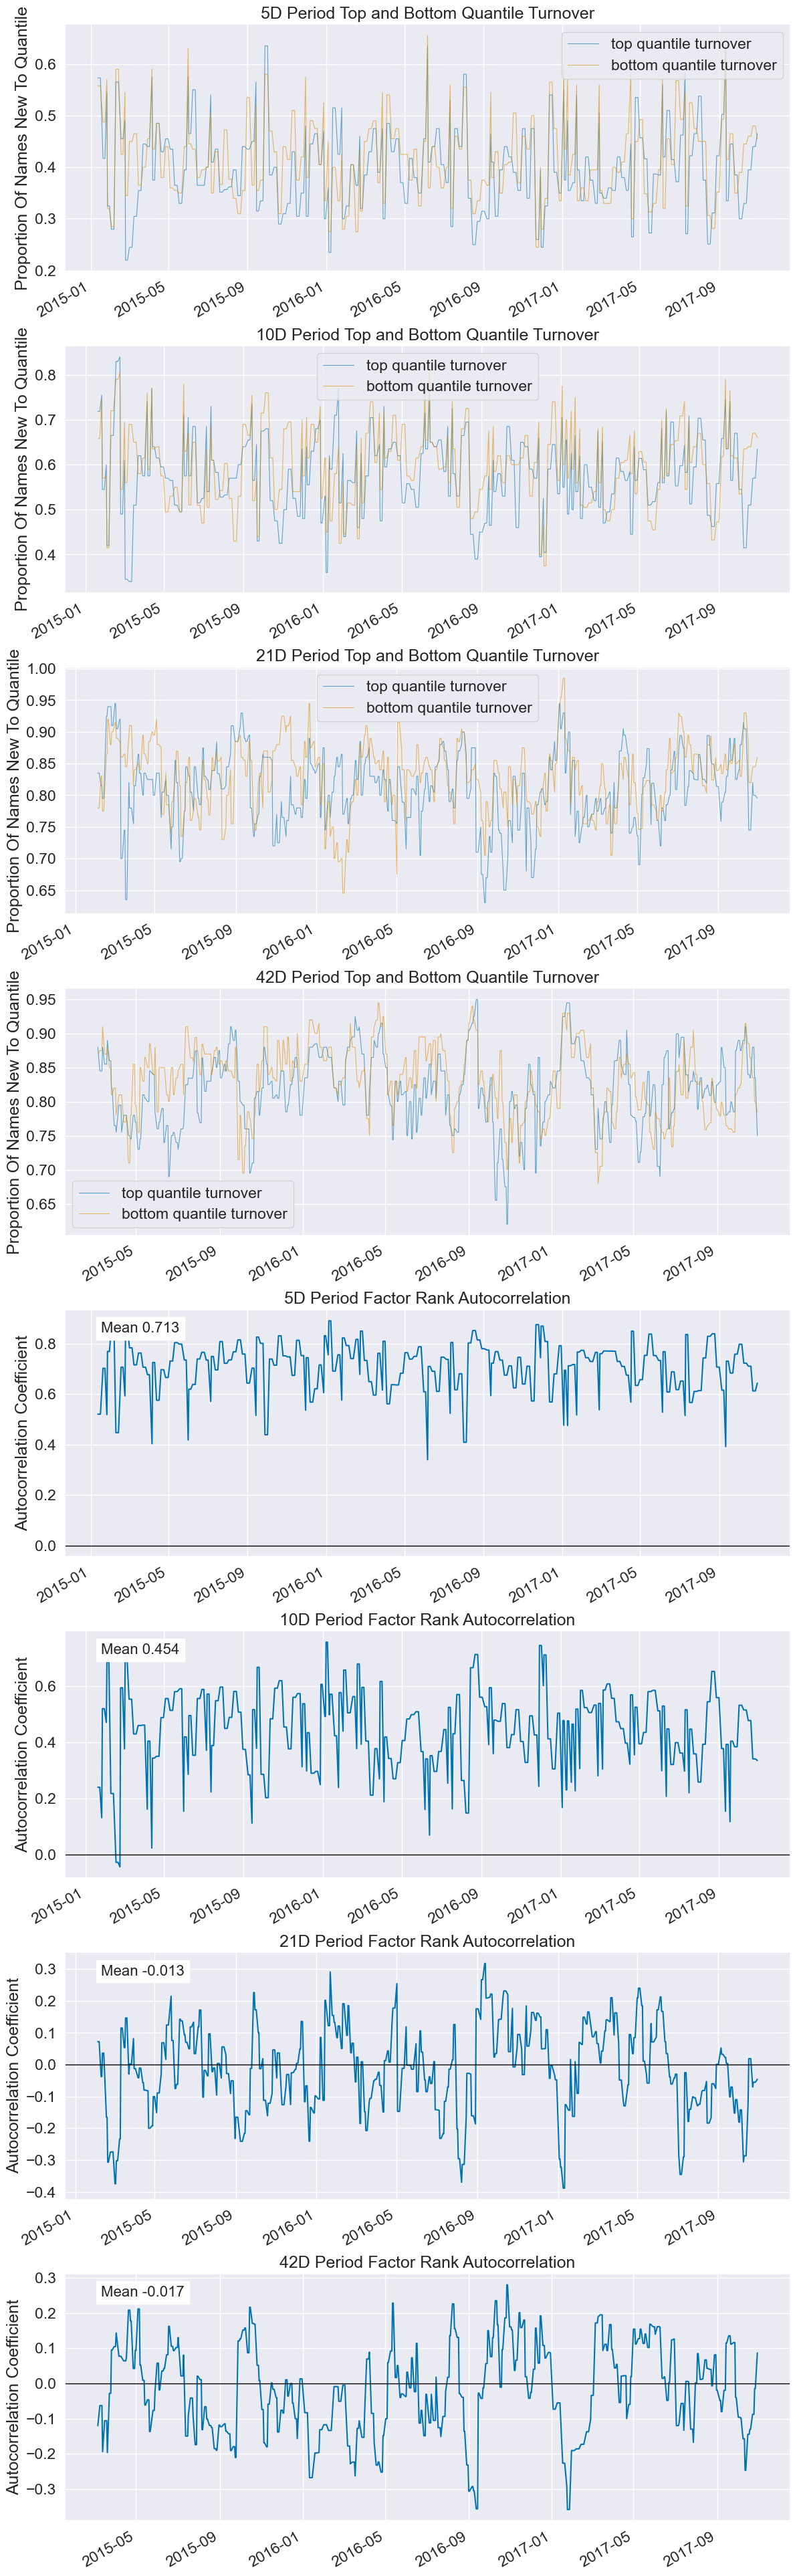

In [38]:
create_turnover_tear_sheet(alphalens_data);